https://www.google.com/search?q=mario+kart+8++deluxe+heavy+mii+stats&sxsrf=ALiCzsYodVuxorJolfCd8-AjoOK5BjtBhA%3A1669174302364&ei=HpR9Y_DxFcXnkPIP_6-YqAM&ved=0ahUKEwjw-PDqrsP7AhXFM0QIHf8XBjUQ4dUDCBA&uact=5&oq=mario+kart+8++deluxe+heavy+mii+stats&gs_lcp=Cgxnd3Mtd2l6LXNlcnAQAzIFCAAQgAQyBQgAEIYDMgUIABCGAzIFCAAQhgM6CggAEEcQ1gQQsAM6BwgAELADEEM6BwgjELACECc6BwgAEIAEEA06BggAEAcQHjoICAAQCBAHEB46BggAEB4QDToICAAQCBAeEA06BQgAEJECOgQIABAeOgYIABAIEB46BggAEBYQHjoKCAAQgAQQhwIQFEoECEEYAEoECEYYAFCeA1ilswdg1rUHaAFwAXgAgAGHAogBtRSSAQYwLjE3LjGYAQCgAQHIAQrAAQE&sclient=gws-wiz-serp

In [133]:
import pandas as pd
pd.set_option('display.max_rows', None)


In [134]:
wr_df = pd.read_parquet('dfs/worldrecords.parquet')
wr_df_slim = wr_df[['track','cc','character','vehicle','tires','glider']]

In [135]:
character_stats = pd.read_parquet('dfs/character_stats_adjusted.parquet')
kart_stats = pd.read_parquet('dfs/kart_stats.parquet')
tires_stats = pd.read_parquet('dfs/tires_stats.parquet')
glider_stats = pd.read_parquet('dfs/glider_stats.parquet')

In [136]:
# get list of stats columns and append them to the world record dataframe
for column in glider_stats.columns:
    if column != 'name':
        wr_df_slim[column] = 0
# wr_df_slim

/var/folders/d8/v4dr08kj4k5c9zv_bg2sv47r0000gn/T/ipykernel_63482/1215767457.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wr_df_slim[column] = 0
/var/folders/d8/v4dr08kj4k5c9zv_bg2sv47r0000gn/T/ipykernel_63482/1215767457.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wr_df_slim[column] = 0
/var/folders/d8/v4dr08kj4k5c9zv_bg2sv47r0000gn/T/ipykernel_63482/1215767457.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [137]:
kart_name_conversion = {
    'W 25 Silver Arrow': 'Mercedes Silver Arrow',
    'Gold Kart': 'Gold Standard'
}
kart_convert = lambda kart_name: kart_name_conversion[kart_name] if kart_name in kart_name_conversion else kart_name

In [138]:
def add_data(row):
    tire_data = tires_stats[tires_stats['tire name'] == row.tires.strip()].drop(['tire name','total'], axis=1).to_numpy()[0]
    kart_name = kart_convert(row.vehicle.strip())
    kart_data = kart_stats[kart_stats['kart part'] == kart_name].drop(['kart part','total'], axis=1).to_numpy()[0]
    glider_data = glider_stats[glider_stats['name'] == row.glider.strip()].drop(['name'], axis=1).to_numpy()[0]
    # print(row.character)

    character_data = character_stats[character_stats['name'] == row.character.strip()].drop('name',axis=1).to_numpy()[0]
    # print(character_data)
    row[['speed','acceleration','weight','handling','traction/grip','mini-turbo']] += kart_data + tire_data + glider_data +character_data
    return row
wr_stats = wr_df_slim.apply(add_data,axis=1).drop(['character','vehicle','tires','glider'], axis=1)

In [139]:
wr_stats_150 = wr_stats[wr_stats['cc']==150]

In [140]:
from sklearn import cluster

In [141]:
num_clusters = 2
model = cluster.KMeans(n_clusters = num_clusters).fit(wr_stats_150.drop('track',axis=1).to_numpy())
wr_stats_150['label'] = model.labels_

/var/folders/d8/v4dr08kj4k5c9zv_bg2sv47r0000gn/T/ipykernel_63482/3034992018.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wr_stats_150['label'] = model.labels_


In [142]:
from matplotlib import pyplot as plt
from itertools import combinations

In [143]:
attributes = wr_stats.columns[3:]
attributes
attribute_colections = list(combinations(attributes,2))

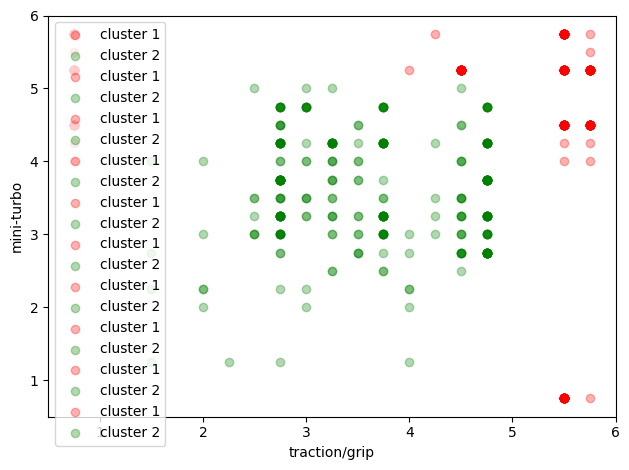

In [144]:
colors = ['red','green','blue','purple','orange','black','tan']
for j, labels in enumerate(attribute_colections):
    x_label, y_label = labels

    # plt.subplot(5,2,j+1)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    for i in range(num_clusters):
        plt.scatter(wr_stats_150[wr_stats_150['label']==i][x_label],wr_stats_150[wr_stats_150['label']==i][y_label], alpha = .3, color=colors[i], label=f'cluster {i+1}')
    # make pretty
    plt.legend()
    plt.tight_layout()
    plt.show()

In [145]:
wr_stats_150[wr_stats_150['label']==0].track.to_list()

['Sweet Sweet Canyon',
 'Thwomp Ruins',
 'Twisted Mansion',
 'Bone-Dry Dunes',
 'Rainbow Road',
 'Wii Moo Moo Meadows',
 'DS Cheep Cheep Beach',
 'GCN Dry Dry Desert',
 'SNES Donut Plains 3',
 'GCN Sherbet Land',
 '3DS Music Park',
 'N64 Yoshi Valley',
 'DS Tick-Tock Clock',
 'Wii Grumble Volcano',
 'GCN Yoshi Circuit',
 'Excitebike Arena',
 'Dragon Driftway',
 'Ice Ice Outpost',
 'GBA Cheese Land',
 'Animal Crossing',
 '3DS Neo Bowser City',
 'Super Bell Subway',
 'Wii Coconut Mall',
 'Tour Tokyo Blur',
 'DS Shroom Ridge',
 'Tour Ninja Hideaway',
 'Tour New York Minute',
 'SNES Mario Circuit 3',
 'N64 Kalimari Desert',
 'DS Waluigi Pinball',
 'GBA Snow Land']